
🚀 Training LinearRegression...

🚀 Training LogisticRegression...

🚀 Training Perceptron...

🚀 Training MLP(ReLU) with weight tracking...


/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hyuksu


✅ Training done on Titanic v1.
                    Accuracy
LinearRegression      0.9573
LogisticRegression    0.9512
Perceptron            0.9573
MLP(ReLU)             0.9543


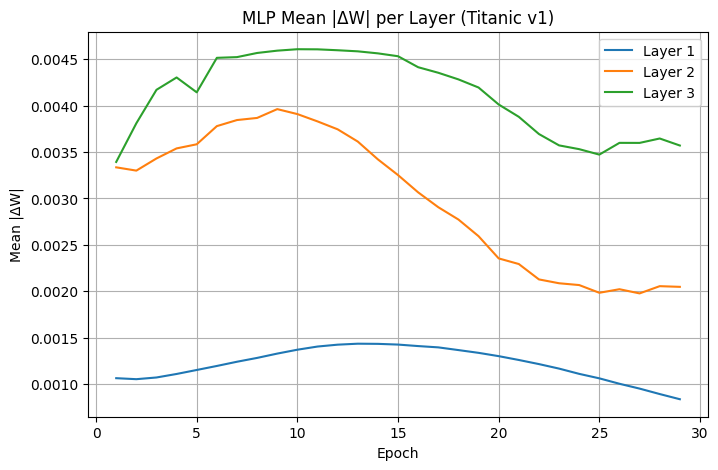

/home/hyuksu/projects/ml/.venv/lib/python3.12/site-packages/sklearn/datasets/_openml.py:74: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Perceptron, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# -----------------------------
# 1) Titanic v1 (학습용)
# -----------------------------
titanic_v1 = fetch_openml(name="titanic", version=1, as_frame=True)
df1 = titanic_v1.frame.copy()

y1 = df1["survived"].astype(int)
X1 = df1.drop(columns=["survived"])

num_cols = X1.select_dtypes(include=['number']).columns.tolist()
cat_cols = X1.select_dtypes(exclude=['number']).columns.tolist()

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    # sparse_output=False (sklearn>=1.2), 구버전이면 sparse=False로 바꿔도 됨
    ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

X1_tr, X1_te, y1_tr, y1_te = train_test_split(
    X1, y1, stratify=y1, test_size=0.25, random_state=42
)

# -----------------------------
# 2) 모델 4개 정의 (KNN 제외)
# -----------------------------
models = {
    "LinearRegression": LinearRegression(),
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=42),
    "Perceptron": Perceptron(max_iter=2000, random_state=42),
    "MLP(ReLU)": MLPClassifier(hidden_layer_sizes=(64, 32),
                               activation='relu', solver='adam',
                               max_iter=1, random_state=42, warm_start=True)
}

# -----------------------------
# 3) 학습 및 평가 (Titanic v1)
# -----------------------------
results = {}

# 비-MLP 모델은 파이프라인 그대로
for name in ["LinearRegression", "LogisticRegression", "Perceptron"]:
    print(f"\n🚀 Training {name}...")
    pipe = Pipeline([("prep", preprocess), ("model", models[name])])
    pipe.fit(X1_tr, y1_tr)
    pred = pipe.predict(X1_te)
    if name == "LinearRegression":
        pred = (pred >= 0.5).astype(int)  # 회귀→이진화
    acc = accuracy_score(y1_te, pred)
    results[name] = acc

# MLP는 에폭별 ΔW 추적
print(f"\n🚀 Training MLP(ReLU) with weight tracking...")
X_tr_prep = preprocess.fit_transform(X1_tr)  # dense 반환
X_te_prep = preprocess.transform(X1_te)

mlp = models["MLP(ReLU)"]
prev_weights = None
mlp_weight_means = None
EPOCHS = 30

for epoch in range(EPOCHS):
    mlp.fit(X_tr_prep, y1_tr.to_numpy())

    # 첫 에폭 종료 시 컨테이너 초기화
    if prev_weights is None:
        prev_weights = [w.copy() for w in mlp.coefs_]
        n_layers = len(mlp.coefs_)               # hidden 개수 + 출력층
        mlp_weight_means = [[] for _ in range(n_layers)]
        continue

    # 평균 |ΔW| 기록
    for i, (pw, cw) in enumerate(zip(prev_weights, mlp.coefs_)):
        diff = np.mean(np.abs(cw - pw))
        mlp_weight_means[i].append(diff)

    prev_weights = [w.copy() for w in mlp.coefs_]

# v1 테스트 성능
pred = mlp.predict(X_te_prep)
results["MLP(ReLU)"] = accuracy_score(y1_te, pred)

print("\n✅ Training done on Titanic v1.")
print(pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).round(4))

# -----------------------------
# 4) MLP layer-wise ΔW 시각화
# -----------------------------
plt.figure(figsize=(8, 5))
for i, deltas in enumerate(mlp_weight_means):
    if deltas:  # 첫 에폭은 비교대상 없음
        plt.plot(range(1, len(deltas)+1), deltas, label=f"Layer {i+1}")
plt.title("MLP Mean |ΔW| per Layer (Titanic v1)")
plt.xlabel("Epoch")
plt.ylabel("Mean |ΔW|")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 5) Titanic v2 (일반화 평가용)
# -----------------------------
titanic_v2 = fetch_openml(name="titanic", version=2, as_frame=True)
df2 = titanic_v2.frame.copy()
y2 = df2["survived"].astype(int)
X2 = df2.drop(columns=["survived"])

# v1에서 fit된 전처리로 변환 (공정 비교)
X2_prep = preprocess.transform(X2)

print("\n📊 Evaluation on Titanic v2 dataset")
# 비-MLP: v1로 다시 학습 후 v2로 예측
for name in ["LinearRegression", "LogisticRegression", "Perceptron"]:
    pipe = Pipeline([("prep", preprocess), ("model", models[name])])
    pipe.fit(X1_tr, y1_tr)
    pred = pipe.predict(X2)
    if name == "LinearRegression":
        pred = (pred >= 0.5).astype(int)
    acc = accuracy_score(y2, pred)
    print(f"{name:>20} | acc = {acc:.4f}")

# MLP: v1에서 학습한 모델로 v2 예측
pred = mlp.predict(X2_prep)
print(f"{'MLP(ReLU)':>20} | acc = {accuracy_score(y2, pred):.4f}")



Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6422 - loss: 0.6834 - val_accuracy: 0.6677 - val_loss: 0.6724
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7064 - loss: 0.6639 - val_accuracy: 0.6677 - val_loss: 0.6580
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7360 - loss: 0.6455 - val_accuracy: 0.6982 - val_loss: 0.6435
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7819 - loss: 0.6266 - val_accuracy: 0.7317 - val_loss: 0.6282
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8043 - loss: 0.6066 - val_accuracy: 0.7622 - val_loss: 0.6119
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8267 - loss: 0.5852 - val_accuracy: 0.7988 - val_loss: 0.5945
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8471 - loss: 0.5625 - val_accuracy: 0.8018 - val_loss: 0.5762
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8593 - loss: 0.5384 - val_accuracy: 0.8110 - val_loss: 0.5571

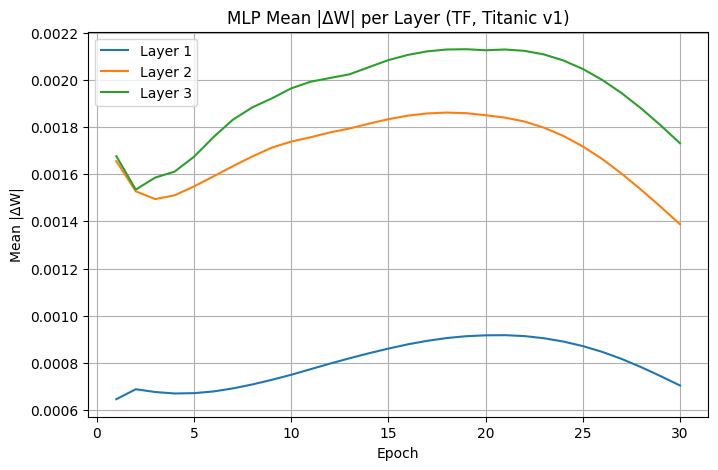

KeyError: 'survived'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Perceptron, LinearRegression
from sklearn.metrics import accuracy_score

# ⬇️ NEW: TensorFlow (CPU oneDNN 최적화)
import tensorflow as tf

# -----------------------------
# 1) Titanic v1 (학습용)
# -----------------------------
titanic_v1 = fetch_openml(name="titanic", version=1, as_frame=True)
df1 = titanic_v1.frame.copy()

y1 = df1["survived"].astype(int)
X1 = df1.drop(columns=["survived"])

num_cols = X1.select_dtypes(include=['number']).columns.tolist()
cat_cols = X1.select_dtypes(exclude=['number']).columns.tolist()

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

X1_tr, X1_te, y1_tr, y1_te = train_test_split(
    X1, y1, stratify=y1, test_size=0.25, random_state=42
)

# 미리 fit (v2에서도 동일 전처리 사용)
X1_tr_prep = preprocess.fit_transform(X1_tr)
X1_te_prep = preprocess.transform(X1_te)

# -----------------------------
# 2) 비-MLP 모델(빠름): 그대로 실행
# -----------------------------
results = {}

# LinearRegression
lin = LinearRegression().fit(X1_tr_prep, y1_tr)
pred = (lin.predict(X1_te_prep) >= 0.5).astype(int)
results["LinearRegression"] = accuracy_score(y1_te, pred)

# LogisticRegression
logr = LogisticRegression(max_iter=2000, random_state=42).fit(X1_tr_prep, y1_tr)
results["LogisticRegression"] = accuracy_score(y1_te, logr.predict(X1_te_prep))

# Perceptron
perc = Perceptron(max_iter=2000, random_state=42).fit(X1_tr_prep, y1_tr)
results["Perceptron"] = accuracy_score(y1_te, perc.predict(X1_te_prep))

# -----------------------------
# 3) MLP를 TensorFlow(Keras)로 교체 + ΔW 추적
# -----------------------------
# 텐서 준비
Xtr = X1_tr_prep.astype("float32")
Xte = X1_te_prep.astype("float32")
ytr = y1_tr.to_numpy().astype("float32")
yte = y1_te.to_numpy().astype("float32")

INPUT_DIM = Xtr.shape[1]
EPOCHS = 30
BATCH = 512

# 모델 정의 (64 -> 32 -> 1, ReLU + Sigmoid)
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(INPUT_DIM,)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

# oneDNN CPU 최적화 + 자동 스레드 사용
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# ΔW(평균 |ΔW|) 추적 콜백
class DeltaWTracker(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Dense 층의 kernel 가중치만 추출
        self.prev = [w.numpy().copy() for layer in self.model.layers
                     if isinstance(layer, tf.keras.layers.Dense)
                     for w in layer.weights if "kernel" in w.name]
        self.means = [[] for _ in self.prev]  # layer-wise 기록

    def on_epoch_end(self, epoch, logs=None):
        cur = [w.numpy().copy() for layer in self.model.layers
               if isinstance(layer, tf.keras.layers.Dense)
               for w in layer.weights if "kernel" in w.name]
        for i, (pw, cw) in enumerate(zip(self.prev, cur)):
            self.means[i].append(float(np.mean(np.abs(cw - pw))))
        self.prev = cur

dw = DeltaWTracker()

# 학습
history = model.fit(
    Xtr, ytr,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=(Xte, yte),
    verbose=1,
    callbacks=[dw]
)

# v1 테스트 성능
pred = (model.predict(Xte, batch_size=BATCH) >= 0.5).astype(int).ravel()
results["MLP(ReLU, TF)"] = accuracy_score(y1_te, pred)

print("\n✅ Training done on Titanic v1.")
print(pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).round(4))

# -----------------------------
# 4) MLP layer-wise ΔW 시각화 (TF 버전)
# -----------------------------
plt.figure(figsize=(8, 5))
for i, deltas in enumerate(dw.means):
    if deltas:
        plt.plot(range(1, len(deltas)+1), deltas, label=f"Layer {i+1}")
plt.title("MLP Mean |ΔW| per Layer (TF, Titanic v1)")
plt.xlabel("Epoch")
plt.ylabel("Mean |ΔW|")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 5) Titanic v2 (일반화 평가용)
# -----------------------------
titanic_v2 = fetch_openml(name="titanic", version=2, as_frame=True)
df2 = titanic_v2.frame.copy()
y2 = df2["survived"].astype(int)
X2 = df2.drop(columns=["survived"])

# v1에서 fit된 전처리로 변환 (공정 비교)
X2_prep = preprocess.transform(X2).astype("float32")

print("\n📊 Evaluation on Titanic v2 dataset")
# 비-MLP: v1 전처리 학습 결과 사용해 v2 예측
print(f"{'LinearRegression':>20} | acc = {accuracy_score(y2, (lin.predict(X2_prep)>=0.5).astype(int)):.4f}")
print(f"{'LogisticRegression':>20} | acc = {accuracy_score(y2, logr.predict(X2_prep)):.4f}")
print(f"{'Perceptron':>20} | acc = {accuracy_score(y2, perc.predict(X2_prep)):.4f}")

# TF MLP: v1 학습 모델로 v2 예측
pred_v2 = (model.predict(X2_prep, batch_size=BATCH) >= 0.5).astype(int).ravel()
print(f"{'MLP(ReLU, TF)':>20} | acc = {accuracy_score(y2, pred_v2):.4f}")


